### Regressao Logistica em R

#### Motivaçao:
 - O conceito do Z-Score
 - Construindo mais variaveis para o modelo
 - Treinamento e avaliaçao do Modelo
 - Area Under the Curve (AUC) ROC e o Gini
 - Resultados:
     - "Retorno de 2009 à 2019:  51.32 %%"
     - "Retorno juros simples por ano:  4.67%"
 - Consideraçoes finais

-------------------------------------------------------------------

### Bibliotecas

In [3]:
library(stats)
library(rattle)
library(caret)
library(ROCR)
library(party)
library(mlbench)
library(quantmod)
library(e1071)
library(data.table)
library(tidyverse)


Attaching package: 'data.table'

The following objects are masked from 'package:xts':

    first, last

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v purrr   0.3.2       v forcats 0.5.1  
Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first(), xts::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last(), xts::last()
x purrr::lift()      masks caret::lift()
x purrr::transpose() masks data.table::transpose()


-----------------------------------------------------------------

### Carregando a base de dados


In [7]:
# Mudando o diretório de trabalho 

setwd('E:/Base de dados')

In [8]:
# Importando arquivos tipo CSV - função fread

# Carregando o Dataset e ajustando a data

EURUSD <- fread("eurusd.csv", header = TRUE, sep = ";")

EURUSD <- data.frame(EURUSD)

names(EURUSD)[1] <- "DATE"

EURUSD$DATE <- as.POSIXct(strptime(EURUSD$DATE, format = "%d/%m/%Y"))

In [9]:
head(EURUSD)
tail(EURUSD)

DATE,Open,High,Low,Close
2003-05-05,1.12728,1.14506,1.12723,1.14338
2003-05-06,1.14297,1.14438,1.13265,1.13647
2003-05-07,1.13605,1.15077,1.13006,1.14996
2003-05-08,1.14932,1.15366,1.14346,1.14877
2003-05-11,1.14888,1.16229,1.14888,1.15427
2003-05-12,1.15357,1.15739,1.14620,1.15120


,DATE,Open,High,Low,Close
4323,2019-11-28,1.09987,1.10179,1.09986,1.10067
4324,2019-11-29,1.10059,1.10282,1.09811,1.10150
4325,2019-12-02,1.10229,1.10907,1.10029,1.10784
4326,2019-12-03,1.10782,1.10934,1.10660,1.10809
4327,2019-12-04,1.10809,1.11161,1.10666,1.10775
4328,2019-12-05,1.10772,1.10772,1.11078,1.10977


--------------------------------------------------------------------

## O Z-Score

In [11]:
# Calculando os retornos e o alvo

# Calculando os retornos e o alvo
EURUSD <- mutate(EURUSD, Close_lead = lead(Close)) # Atrasando os valores
EURUSD <- mutate(EURUSD, Close_lag = lag(Close)) # vai criar um NA na primeira linha

EURUSD <- na.omit(EURUSD)

EURUSD$Return <- (EURUSD$Close/EURUSD$Close_lag-1)*100
EURUSD$Alvo1 <- (EURUSD$Close_lead/EURUSD$Close-1)*100
EURUSD$Alvo1_Bin <- ifelse(EURUSD$Alvo1 > 0, 1,0)



head(EURUSD)

,DATE,Open,High,Low,Close,Close_lead,close_lag,Close_lag,Return,Alvo1,Alvo1_Bin
2,2003-05-07,1.13605,1.15077,1.13006,1.14996,1.14877,1.13647,1.13647,1.1870089,-0.1034819,0
3,2003-05-08,1.14932,1.15366,1.14346,1.14877,1.15427,1.14996,1.14996,-0.1034819,0.4787729,1
4,2003-05-11,1.14888,1.16229,1.14888,1.15427,1.15120,1.14877,1.14877,0.4787729,-0.2659690,0
5,2003-05-12,1.15357,1.15739,1.14620,1.15120,1.14940,1.15427,1.15427,-0.2659690,-0.1563586,0
6,2003-05-13,1.15120,1.15370,1.14667,1.14940,1.13847,1.15120,1.15120,-0.1563586,-0.9509309,0
7,2003-05-14,1.14913,1.14967,1.13744,1.13847,1.15705,1.14940,1.14940,-0.9509309,1.6320149,1


In [12]:
# Calculando o Z-Score
library(caTools)

Warning message:
"package 'caTools' was built under R version 3.6.3"

In [13]:
# calculando a média movel dos retornos e o desvio padrão

periodo_mm <- 15

EURUSD$MA_Return <- c(rep(NA, periodo_mm-1), runmean(EURUSD$Return, periodo_mm, alg=c("C"), endrule = c("trim"))) 

EURUSD$SD_Return <- c(rep(NA, periodo_mm-1), runsd(EURUSD$Return, periodo_mm, endrule = c("trim")))

EURUSD$ZScore <- (EURUSD$Return-EURUSD$MA_Return)/EURUSD$SD_Return

head(EURUSD)

write.csv(EURUSD,"teste_media.csv", row.names = FALSE)

,DATE,Open,High,Low,Close,Close_lead,close_lag,Close_lag,Return,Alvo1,Alvo1_Bin,MA_Return,SD_Return,ZScore
2,2003-05-07,1.13605,1.15077,1.13006,1.14996,1.14877,1.13647,1.13647,1.1870089,-0.1034819,0,NA,NA,NA
3,2003-05-08,1.14932,1.15366,1.14346,1.14877,1.15427,1.14996,1.14996,-0.1034819,0.4787729,1,NA,NA,NA
4,2003-05-11,1.14888,1.16229,1.14888,1.15427,1.15120,1.14877,1.14877,0.4787729,-0.2659690,0,NA,NA,NA
5,2003-05-12,1.15357,1.15739,1.14620,1.15120,1.14940,1.15427,1.15427,-0.2659690,-0.1563586,0,NA,NA,NA
6,2003-05-13,1.15120,1.15370,1.14667,1.14940,1.13847,1.15120,1.15120,-0.1563586,-0.9509309,0,NA,NA,NA
7,2003-05-14,1.14913,1.14967,1.13744,1.13847,1.15705,1.14940,1.14940,-0.9509309,1.6320149,1,NA,NA,NA


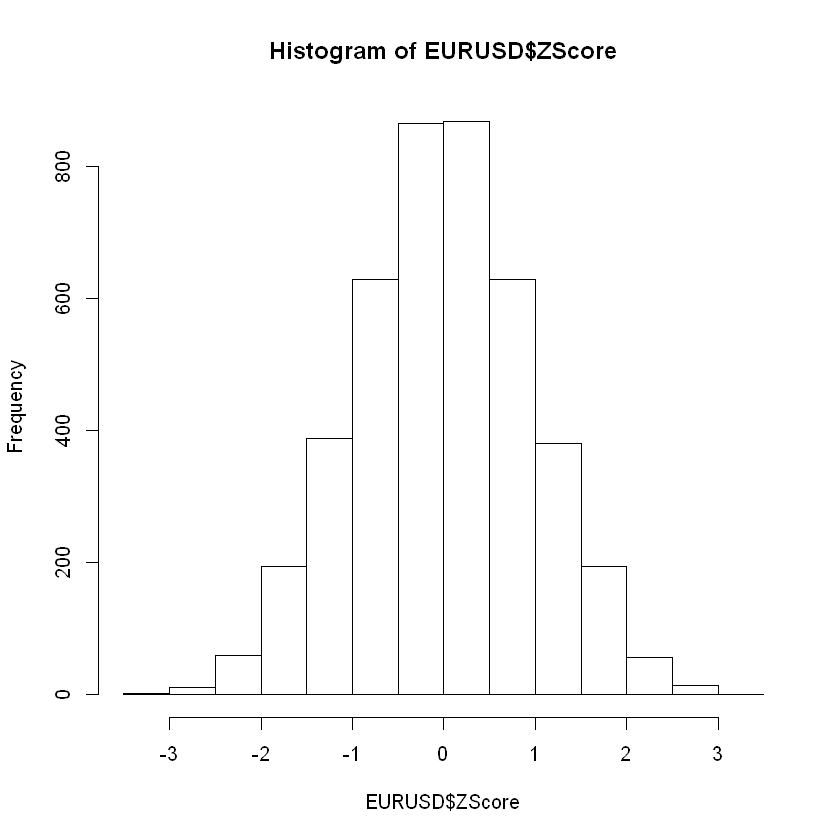

In [14]:
hist(EURUSD$ZScore)

In [15]:
# Calculando o RSL

EURUSD$MA_Close <- c(rep(NA, periodo_mm-1), runmean(EURUSD$Close,periodo_mm, alg=c("C"), endrule=c("trim")))
EURUSD$RSL <- (EURUSD$Close/EURUSD$MA_Close-1)

EURUSD <- na.omit(EURUSD)

tail(EURUSD)

,DATE,Open,High,Low,Close,Close_lead,close_lag,Close_lag,Return,Alvo1,Alvo1_Bin,MA_Return,SD_Return,ZScore,MA_Close,RSL
4306,2019-11-26,1.10115,1.10256,1.10071,1.10194,1.09989,1.10126,1.10126,0.06174745,-0.18603554,0,-0.032916297,0.1790719,0.52863541,1.103863,-0.001741763
4307,2019-11-27,1.10194,1.10246,1.09922,1.09989,1.10067,1.10194,1.10194,-0.18603554,0.07091618,1,-0.040261868,0.1831719,-0.79582996,1.103417,-0.003196133
4308,2019-11-28,1.09987,1.10179,1.09986,1.10067,1.10150,1.09989,1.09989,0.07091618,0.07540861,1,-0.025834568,0.1828137,0.52923144,1.103130,-0.002230018
4309,2019-11-29,1.10059,1.10282,1.09811,1.10150,1.10784,1.10067,1.10067,0.07540861,0.57557876,1,-0.001440285,0.1688543,0.45511949,1.103113,-0.001461924
4310,2019-12-02,1.10229,1.10907,1.10029,1.10784,1.10809,1.10150,1.10150,0.57557876,0.02256644,1,0.028036773,0.2237496,2.44711922,1.103420,0.004005728
4311,2019-12-03,1.10782,1.10934,1.10660,1.10809,1.10775,1.10784,1.10784,0.02256644,-0.03068343,0,0.043741928,0.2136621,-0.09910741,1.103901,0.003795027


In [16]:
# Treinamento e teste - 2003-2008
desenvolvimento <- EURUSD[1:1443,]

In [17]:
summary(desenvolvimento$ZScoreQ)

Length  Class   Mode 
     0   NULL   NULL 

In [18]:
# Será que o z-score ajudar a encontrar regioes mais rentaveis?

q <- quantile(desenvolvimento$ZScore, seq(0, 1, by = 0.05))

desenvolvimento$ZScoreQ <- cut(desenvolvimento$ZScore, q, include.lowest = TRUE)

Returs_ZScore <- aggregate(Alvo1 ~ ZScoreQ, data = desenvolvimento, FUN = sum)
Returs_ZScore

ZScoreQ,Alvo1
"[-2.69,-1.61]",-3.34965530
"(-1.61,-1.27]",-4.97776065
"(-1.27,-1.02]",-3.81975574
"(-1.02,-0.84]",6.69581583
"(-0.84,-0.675]",3.40152986
"(-0.675,-0.501]",4.06369720
"(-0.501,-0.367]",4.55802842
"(-0.367,-0.237]",10.15127320
"(-0.237,-0.124]",4.01065582
"(-0.124,-0.0134]",2.77089484


In [19]:
# Sera que o RSL ajuda a encontrar regioes mais rentaveis?

q <- quantile(desenvolvimento$RSL, seq(0,1, by = 0.1))
desenvolvimento$RSLQ <- cut(desenvolvimento$RSL, q, include.lowest = TRUE)

Returns_RSL <- aggregate(Alvo1 ~ RSLQ, data = desenvolvimento, FUN =sum)
Returns_RSL

RSLQ,Alvo1
"[-0.0596,-0.0151]",2.9164169
"(-0.0151,-0.00953]",-6.1754630
"(-0.00953,-0.0053]",7.0181737
"(-0.0053,-0.00213]",3.2850735
"(-0.00213,0.00126]",0.4238728
"(0.00126,0.0043]",6.9645742
"(0.0043,0.00777]",-9.0752625
"(0.00777,0.0115]",10.6524868
"(0.0115,0.0158]",5.4880128
"(0.0158,0.0388]",-3.6453563


-----------------------------------------------------------------

### Construindo mais variaveis p/ o modelo

In [21]:
# Criando os indicadores técnicos 

EURUSD$RSI <- RSI(EURUSD$Close, 14, "SMA")
EURUSD$RSI2 <- RSI(EURUSD$Close, 2, "SMA")
EURUSD$CCI <- CCI(EURUSD$Close, 14)
EURUSD$MACD <- MACD(EURUSD$Close, 12, 26, 9, "SMA")
EURUSD$MACD <- EURUSD$MACD[,1] - EURUSD$MACD[,2]
EURUSD$Bbands <- BBands(EURUSD$Close, 20, "SMA", 2)[,4]

In [32]:
# Criando as variaveis

EURUSD$ZScoreBin <- ifelse((EURUSD$ZScore <- -1.02 | (EURUSD$ZScore > 0.476 & EURUSD$ZScore <= 1.62))
    , 1, 0)
EURUSD$RSLBin <- ifelse((
    (EURUSD$RSL > -0.00956 & EURUSD$RSL <= -0.00523)|
    (EURUSD$RSL > 0.00981 & EURUSD$RSL <= 0.0135)|
    (EURUSD$RSL > 0.00149 & EURUSD$RSL <= 0.00438)
    )
    , 1, 0)

EURUSD$RSIH <- ifelse(EURUSD$RSI > 70, 1, 0)
EURUSD$RSIL <- ifelse(EURUSD$RSI < 30, 1, 0)
EURUSD$RSI2H <- ifelse(EURUSD$RSI2 > 70, 1, 0)
EURUSD$RSI2L <- ifelse(EURUSD$RSI < 30, 1, 0)
EURUSD$CCIH <- ifelse(EURUSD$CCI > 120, 1, 0)
EURUSD$CCIL <- ifelse(EURUSD$CCI < -120, 1, 0)
EURUSD$MACDH <- ifelse(EURUSD$MACD > 0.5, 1, 0)
EURUSD$MACDL <- ifelse(EURUSD$MACD < -0.5, 1, 0)

EURUSD <- na.omit(EURUSD)

names(EURUSD)


[1] "DATE"       "Open"       "High"       "Low"        "Close"     
 [6] "Close_lead" "close_lag"  "Close_lag"  "Return"     "Alvo1"     
[11] "Alvo1_Bin"  "MA_Return"  "SD_Return"  "ZScore"     "MA_Close"  
[16] "RSL"        "RSI"        "RSI2"       "CCI"        "MACD"      
[21] "Bbands"     "ZScoreBin"  "RSIH"       "RSIL"       "RSI2H"     
[26] "RSI2L"      "CCIH"       "CCIL"       "MACDH"      "MACDL"     
[31] "RSLBin"

---------------------------------------------------------------------

### Treinamento do modelo

In [44]:
# Treinamento e teste - 2003-2008
desenvolvimento <- EURUSD[1:1443,]

# Validação 2009-2019
validacao <- EURUSD[1444:dim(EURUSD)[1],]

tail(desenvolvimento)

,DATE,Open,High,Low,Close,Close_lead,close_lag,Close_lag,Return,Alvo1,...,ZScoreBin,RSIH,RSIL,RSI2H,RSI2L,CCIH,CCIL,MACDH,MACDL,RSLBin
1486,2009-01-21,1.29047,1.30855,1.28235,1.30215,1.30000,1.29037,1.29037,0.9129165,-0.1651115,...,1,0,1,0,1,0,0,0,1,0
1487,2009-01-22,1.30210,1.30820,1.29085,1.30000,1.29725,1.30215,1.30215,-0.1651115,-0.2115385,...,1,0,1,1,1,0,0,0,1,0
1488,2009-01-23,1.29990,1.30345,1.27675,1.29725,1.31875,1.30000,1.30000,-0.2115385,1.6573521,...,1,0,1,0,1,0,0,0,1,0
1489,2009-01-26,1.29621,1.32070,1.28610,1.31875,1.31595,1.29725,1.29725,1.6573521,-0.2123223,...,1,0,0,1,0,0,0,0,1,0
1490,2009-01-27,1.31875,1.33290,1.31165,1.31595,1.31650,1.31875,1.31875,-0.2123223,0.0417949,...,1,0,0,1,0,0,0,0,0,0
1491,2009-01-28,1.31595,1.33230,1.31015,1.31650,1.29541,1.31595,1.31595,0.0417949,-1.6019749,...,1,0,0,0,0,0,0,0,0,0


In [45]:
set.seed(42)
inTrain <- createDataPartition(y = desenvolvimento$Alvo1_Bin, p = 0.7, list= FALSE)
training <- desenvolvimento[inTrain,]
testing <- desenvolvimento[-inTrain,]
dim(training); dim(testing)

[1] 1011   31

[1] 432  31

In [46]:
# Regressão Logística

modelo1 <- glm(Alvo1_Bin ~ ZScoreBin + RSLBin + RSIH + RSIL + RSI2H + RSI2L + Bbands + MACDH + MACDL + CCIH + CCIL,
                 data = training, family = binomial(link = 'logit'))  

summary(modelo1)


Call:
glm(formula = Alvo1_Bin ~ ZScoreBin + RSLBin + RSIH + RSIL + 
    RSI2H + RSI2L + Bbands + MACDH + MACDL + CCIH + CCIL, family = binomial(link = "logit"), 
    data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.4882  -1.1436   0.9352   1.1239   1.6235  

Coefficients: (2 not defined because of singularities)
            Estimate Std. Error z value Pr(>|z|)   
(Intercept)  0.16083    0.19719   0.816  0.41475   
ZScoreBin         NA         NA      NA       NA   
RSLBin       0.28174    0.14244   1.978  0.04793 * 
RSIH         0.08815    0.20319   0.434  0.66441   
RSIL         0.24092    0.25819   0.933  0.35076   
RSI2H       -0.41895    0.15354  -2.729  0.00636 **
RSI2L             NA         NA      NA       NA   
Bbands       0.08063    0.34943   0.231  0.81750   
MACDH       -0.60329    0.23289  -2.590  0.00958 **
MACDL       -0.49551    0.23793  -2.083  0.03729 * 
CCIH        -0.21082    0.23241  -0.907  0.36436   
CCIL        -0.03236  

------------------------------------------------------------------

### Avaliação do modelo 1 - Teste

In [47]:
modelo1


Call:  glm(formula = Alvo1_Bin ~ ZScoreBin + RSLBin + RSIH + RSIL + 
    RSI2H + RSI2L + Bbands + MACDH + MACDL + CCIH + CCIL, family = binomial(link = "logit"), 
    data = training)

Coefficients:
(Intercept)    ZScoreBin       RSLBin         RSIH         RSIL        RSI2H  
    0.16083           NA      0.28174      0.08815      0.24092     -0.41895  
      RSI2L       Bbands        MACDH        MACDL         CCIH         CCIL  
         NA      0.08063     -0.60329     -0.49551     -0.21082     -0.03236  

Degrees of Freedom: 1010 Total (i.e. Null);  1001 Residual
Null Deviance:	    1401 
Residual Deviance: 1375 	AIC: 1395

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

[1] 0.54

[1] 0.08

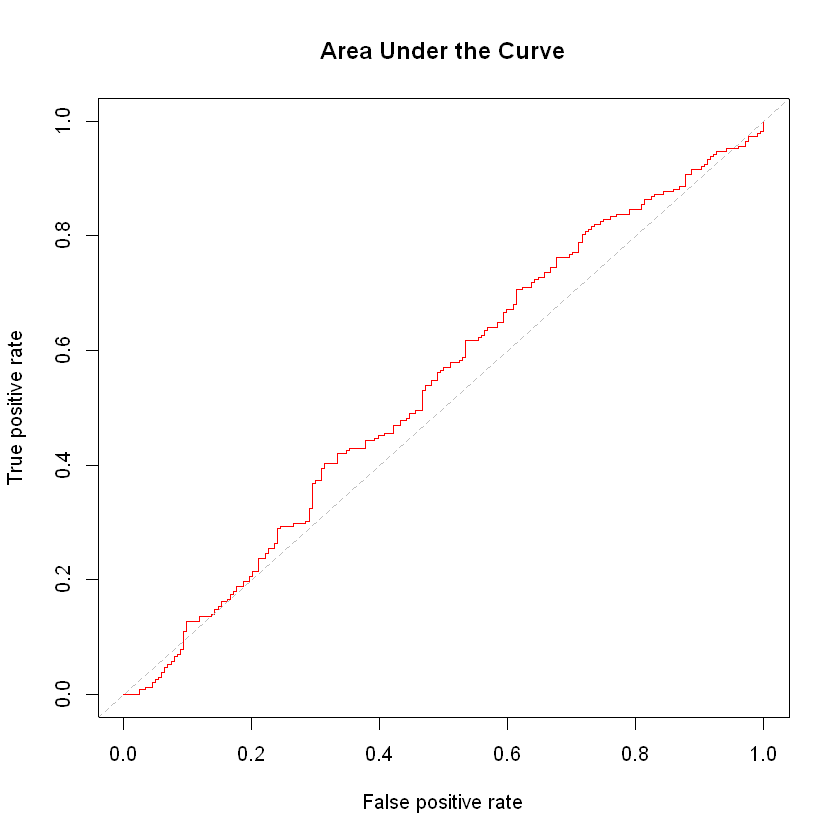

In [48]:
# Plota a AUC

probabilidades <- predict(modelo1, type = 'response', testing) 
modelo1_data <- prediction(probabilidades, testing$Alvo1_Bin)
plot(performance(modelo1_data, "tpr", "fpr"), col = "red", main = "Area Under the Curve")
abline(0,1, lty = 8, col = "grey")

# AUC
auc_rdock <- performance(modelo1_data, "auc")
auc.area_rdock <- slot(auc_rdock, "y.values")[[1]]
round(auc.area_rdock, 2)

# Gini
gini_fin_test <- 2*auc.area_rdock-1
round(gini_fin_test, 2)

In [49]:
# Ordenação por classe de score

classe <- cut(probabilidades, quantile(probabilidades, seq(0,1,0.15)))

table(classe, testing$Alvo1_Bin)

               
classe           0  1
  (0.269,0.408] 35 29
  (0.408,0.444] 35 30
  (0.444,0.477] 28 36
  (0.477,0.531] 31 34
  (0.531,0.55]  27 38
  (0.55,0.613]  29 35

In [50]:
corte_low <- 0.396
corte_up <- 0.606

-----------------------------------------------------------------

### Avaliação da Performance

Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
"prediction from a rank-deficient fit may be misleading"

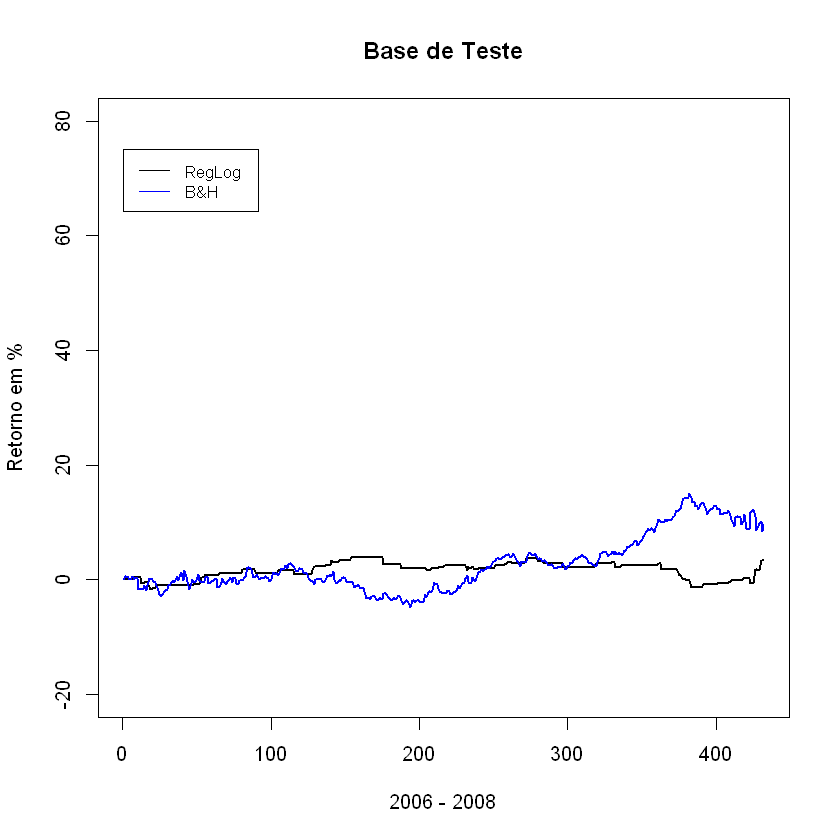

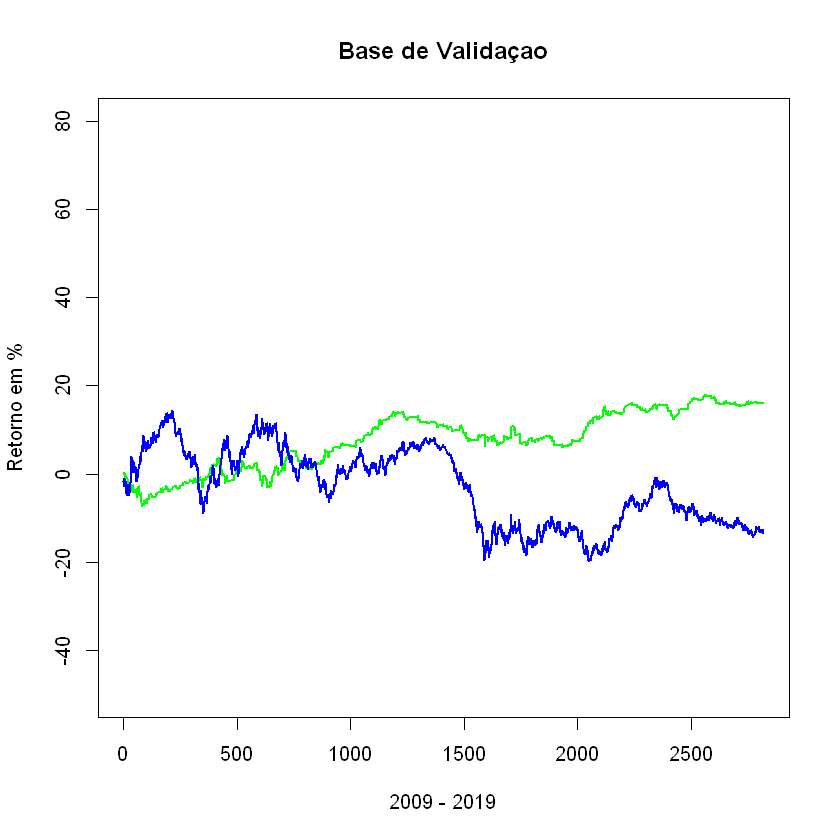

In [51]:
par(mfrow=c(1,1))

# Custos operacionais
custo_op <- 0.01 # Em percentual - No forex é realmente muito baixo.

# Teste
testing$predicao <- predict(modelo1, type='response',testing) 

retorno_BH <- ifelse(testing$Return > 0, testing$Return, testing$Return)
retorno_BH_acumulado <- cumsum(retorno_BH)

retorno_modelo1 <- ifelse(testing$predicao > corte_up, testing$Alvo1 - custo_op,
                          ifelse(testing$predicao < corte_low, -1*testing$Alvo1 - custo_op,0))

retorno_modelo1_acumulado <- cumsum(retorno_modelo1)


plot(retorno_modelo1_acumulado, type = "l", col = "black", lwd = 2,
     main = "Base de Teste",
     xlab = "2006 - 2008",
     ylab = "Retorno em %",
     ylim = c(-20,80))
lines(retorno_BH_acumulado,col = "blue", lwd = 2)

legend(1, 75, legend = c("RegLog","B&H"),
       col = c("black","blue"), lty = 1:1, cex = 0.8)


# Validacao
validacao$predicao <- predict(modelo1, type ='response', validacao) 

retorno_BH <- ifelse(validacao$Return > 0, validacao$Return, validacao$Return)
retorno_BH_acumulado <- cumsum(retorno_BH)

retorno_modelo1 <- ifelse(validacao$predicao > corte_up, validacao$Alvo1 - custo_op,
                          ifelse(validacao$predicao < corte_low, -1*validacao$Alvo1 - custo_op,0))

retorno_modelo1_acumulado <- cumsum(retorno_modelo1)

# Grafico da Performance

plot(retorno_modelo1_acumulado, type = "l", col = "green", lwd = 2,
     main = "Base de Validaçao",
     xlab = "2009 - 2019",
     ylab = "Retorno em %",
     ylim = c(-50,80))
lines(retorno_BH_acumulado, col = "blue", lwd = 2)

legend(1, 160, legend = c("RegLog", "B&H"),
       col = c("green","blue"), lty = 1:1, cex = 0.8)

In [52]:
# Retorno acumulado em quase 11 anos

print(paste("Retorno de 2009 à 2019: " ,round(last(retorno_modelo1_acumulado),2), "%"))

print(paste("Retorno juros simples por ano: " ,round(last(retorno_modelo1_acumulado)/11,2), "%"))

[1] "Retorno de 2009 à 2019:  16.09 %"
[1] "Retorno juros simples por ano:  1.46 %"


---------------------------------------------------------------

### Consideraçoes Finais

 - A avaliaçao de performance nao è com juros compostos, apenas simples e sem aumento de capital
 - Ou seja, os retornos podem ser muito maiores
 - Os custos operacionais sao baixos no Forex, mas possuem impacto relevante em mercados como o do Brasil
 - Os Ginis sao medianos;
 - Porém, no mercado financeiro qualquer coisa que acerte mais que uma moeda te dà um alpha
